# Chapter: Proximity-based Techniques for Detection


# Topic: Process Fault Detection via LOF

In [11]:
# packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [12]:
# fetch data
import scipy.io

matlab_data = scipy.io.loadmat('MACHINE_Data.mat', struct_as_record = False)
Etch_data = matlab_data['LAMDATA']
calibration_dataAll = Etch_data[0,0].calibration # calibration_dataAll[i,0] corresponds to a 2D data from ith batch where columns correspond to different variables 

variable_names = Etch_data[0,0].variables

In [13]:
# generate unfolded data matrix
n_vars = variable_names.size - 2 # first 2 columns are not process variables
n_samples = 85 # following the work of He et al.

unfolded_dataMatrix = np.empty((1,n_vars*n_samples))
for expt in range(calibration_dataAll.size):
    calibration_expt = calibration_dataAll[expt,0][5:90,2:] # removing first 5 measurements as done in He et al.
    
    if calibration_expt.shape[0] < 85:
        continue
    
    unfolded_row = np.ravel(calibration_expt, order='F')[np.newaxis,:]
    unfolded_dataMatrix = np.vstack((unfolded_dataMatrix, unfolded_row))

unfolded_dataMatrix = unfolded_dataMatrix[1:,:]

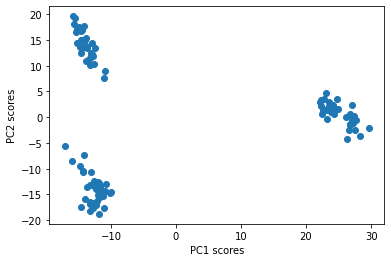

In [14]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#               Fit PCA and use PC scores as model inputs
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# scale data & fit PCA model via pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = 3))])
score_train = pipe.fit_transform(unfolded_dataMatrix)

# visualize in 2D
plt.figure()
plt.scatter(score_train[:,0],score_train[:,1])
plt.xlabel('PC1 scores')
plt.ylabel('PC2 scores')
plt.show()

In [15]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                       Fit LOF model
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
from sklearn.neighbors import LocalOutlierFactor

lof_model = LocalOutlierFactor(n_neighbors=5, novelty=True, contamination=0.05)
lof_model.fit(score_train)

lof_train = -lof_model.negative_outlier_factor_ # negative_outlier_factor_ gives the opposite LOF of the training samples
lof_CL = -lof_model.offset_

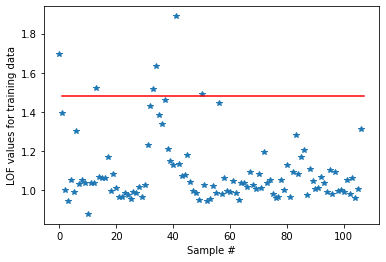

In [16]:
# monitoring chart for training data
plt.figure()
plt.plot(lof_train, '*')
plt.plot([1,len(lof_train)],[lof_CL, lof_CL], color='red')
plt.xlabel('Sample #')
plt.ylabel('LOF values for training data')
plt.show()

In [17]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                        test data
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [18]:
# fetch test data and unfold
test_dataAll = Etch_data[0,0].test

unfolded_TestdataMatrix = np.empty((1,n_vars*n_samples))
for expt in range(test_dataAll.size):
    test_expt = test_dataAll[expt,0][5:90,2:]
    
    if test_expt.shape[0] < 85:
        continue
    
    unfolded_row = np.ravel(test_expt, order='F')[np.newaxis,:]
    unfolded_TestdataMatrix = np.vstack((unfolded_TestdataMatrix, unfolded_row))

unfolded_TestdataMatrix = unfolded_TestdataMatrix[1:,:]

# scale and PCA on faulty test data
score_test = pipe.transform(unfolded_TestdataMatrix)


Number of flagged faults (using control chart):  16
Number of flagged faults (using predict function):  16


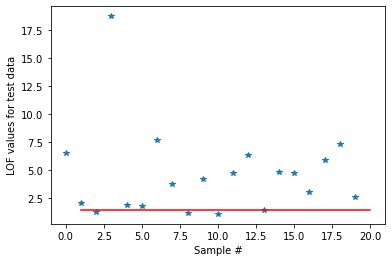

In [19]:
# lof_test
lof_test = -lof_model.score_samples(score_test)
print('Number of flagged faults (using control chart): ', np.sum(lof_test > lof_CL))

# can also use predict() function of LOF class to flag faulty samples
print('Number of flagged faults (using predict function): ', np.sum(lof_model.predict(score_test) == -1))

# monitoring chart for test data
plt.figure()
plt.plot(lof_test, '*')
plt.plot([1,len(lof_test)],[lof_CL, lof_CL], color='red')
plt.xlabel('Sample #')
plt.ylabel('LOF values for test data')
plt.show()